# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

from Timer import Timer
import logging

In [2]:
import pytest
from ipytest import run_pytest, clean_tests

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 11189 / 11441 MB available
Created context handle <28257376>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Colombi_Francesco/MilanoGPU2018/notebooks/cuda_cache


In [4]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");
# Prepare kernel to be launched
# matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols)
# Pointer, Pointer, Pointer, integer, integer
# PPPii
kernel.prepare('PPPii')

In [5]:
def gpuMatrixVector(a, b):
    # create a stream of operation on the gpu
    stream = 
    
    # synchonize to have a nice benchmarking and timing the actual time to do stuffs
    execute.synchronize()
    
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    
    # add timer data allocation on gpu
    a_g = GPUArray(a.shape, np.float32)
    b_g = GPUArray(b.shape, np.float32)
    c_g = GPUArray(a.shape[0], np.float32)
    execute.synchronize()
    
    # add timer import a
    a_g.set(a)
    execute.synchronize()
    
    # add timer import b
    b_g.set(b)
    execute.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (1, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / block_size[0])), 1, 1)
    
    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    
    #Execute program on device
    # add timer kernel execution
    kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
    execute.synchronize()
    
    #Copy data from device to host
    # add timer allocation c
    c = np.empty((a.shape[0],1), dtype=np.float32)
    execute.synchronize()
    
    # add timer download c
    c_g.get(c)
    execute.synchronize()
    
    #Return our computed matrix-vector product
    return c

In [6]:
nx = np.array([200,400,800,1600])
ny = nx

[[0.10753886 0.44540027 0.68519485]
 [0.09995306 0.03458656 0.5965329 ]
 [0.70343673 0.3281439  0.6128605 ]
 [0.9476809  0.80626    0.7799923 ]]
[[0.18387796]
 [0.4529107 ]
 [0.3583098 ]]
Block size is (128, 1, 1)
Grid size is (1, 1, 1)
[[0.4670126 ]
 [0.24778737]
 [0.4975603 ]
 [0.8189003 ]]


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


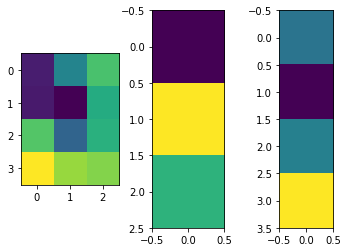

In [6]:
#Size of our test
test_size = (4, 3)
//test_size = (400, 300)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
c = gpuMatrixVector(a, b)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

In [7]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 0.000000119209289550781250000000
Per element error: 3.9736429850260414e-08


In [8]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1,1), dtype=np.float32)
    b = 2*np.ones((1,1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    print(c)
    assert c == pytest.approx(2.0)
    
    #Test the inner product works
    a = np.ones((1,2), dtype=np.float32)
    b = 2*np.ones((2,1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(np.dot(a,b))
    
run_pytest(filename='MatrixVectorTesting.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Colombi_Francesco/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

MatrixVectorTesting.py::test_gpuMatrixVector <- <ipython-input-8-f7e6bd68b4af> PASSED [100%]

=============================== warnings summary ===============================
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: get() between arrays of different shape is

0